In [1]:
import pickle
import numpy as np
import pandas as pd
import ruptures as rpt
from pathlib import Path
from scipy.io import loadmat
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from step.data import *
from step.models import *
#from step.utils import diffusion_coefficient_tmsd

from tqdm.auto import tqdm
from fastai.vision.all import *
from scipy.optimize import curve_fit

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_14152\1401684556.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Analysis functions

In [5]:
# Defino esto aquí para que no tengas que instalar la librería
def tamsd(x, dt=1):
    "Computes the time averaged mean squared displacement of a trajectory `x`."
    return ((x[dt:] - x[:-dt])**2).sum(-1).mean()

def diffusion_coefficient_tamsd(x, t_lag=[1, 2]):
    "Estimates the diffusion coefficient fitting the `tmsd` for different `dt`."
    tamsds = [tamsd(x, dt) for dt in t_lag]
    D = np.polyfit(t_lag, tamsds, 1)[0]
    return D/2/x.shape[-1]

In [6]:
import math
 
def get_angle(a, b, c):
    vector_1 = b - a
    vector_2 = c - b 
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    ang = math.degrees(np.arccos(dot_product))
    d = np.cross(vector_2,vector_1)
    return ang if d < 0 else -ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

def confinement_radius(x, nm_per_pxl=160):
    """Compute the confinement radius of a trajectory segment."""
    cov = np.cov(x)
    e_vals, _ = np.linalg.eigh(cov)
    return 2 * nm_per_pxl * np.sqrt(e_vals.mean())

## Load the data

We start our analysis by loading the trajectories with their predictions.

In [7]:
import mat73

In [8]:
##Processing for multiple Matlab variables
from tkinter import Tk, filedialog

In [9]:
# Create the Tkinter root window
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [10]:
all_trajectories, all_close = [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories = []
    close_log = []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 1 and len(c) > 1:  # At least > 0
            traj = torch.stack((x - x[0], y - y[0]))
            trajectories.append(traj)
            close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories.extend(trajectories)
    all_close.extend(close_log)

In [11]:
# Create the Tkinter root window for the second dataset
root = Tk()
root.withdraw()
root.attributes('-topmost',True)

# Use the file dialog to select multiple files
data_paths = filedialog.askopenfilenames(
    title="Select MATLAB Files",
    filetypes=[("MATLAB files", "*.mat")],
    initialdir="E:\Shares\SMB_files\Jessica",
)

In [12]:
all_trajectories2, all_close2 = [], []
for path in data_paths:
    file = mat73.loadmat(path)

    # Extract x and y data from the current file
    data_x, data_y = file["var1"][0:2]
    close = file["var1"][2]
    
    # Create a list to store trajectories for the current file
    trajectories = []
    close_log = []

    # Loop through x and y data and create trajectories
    for x, y, c in zip(data_x, data_y, close):
        x = torch.tensor(x[~np.isnan(x)])
        y = torch.tensor(y[~np.isnan(y)])
        c = torch.tensor(c[~np.isnan(c)])
        if len(x) > 1 and len(c) > 1:  # At least > 0
            traj = torch.stack((x - x[0], y - y[0]))
            trajectories.append(traj)
            close_log.append(c)

    # Append trajectories of the current file to the overall list
    all_trajectories2.extend(trajectories)
    all_close2.extend(close_log)

# Load the model

In [13]:
model_dir = "../../models"
dim = 2

In [14]:
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets

# Diffusion coefficient
# model_diff = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
#                  n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-3.1, 3.1))
# model_diff = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
#                  n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-4.1, 4.1))
model_diff = LogXResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], pos_enc=False,
                         n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[], norm=False, yrange=(-7.1, 2.1))
model_diff.to(default_device())

# Anomalous exponent
model_exp = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1, 1], block_szs=[128, 256, 512], 
                     pos_enc=False, n_encoder_layers=4, dim_ff=512, nhead_enc=8, linear_layers=[])
model_exp.to(default_device())

# Create the learners
learn_diff = Learner(dls, model_diff, loss_func=L1LossFlat(), model_dir=model_dir)
learn_exp = Learner(dls, model_exp, loss_func=L1LossFlat(), model_dir=model_dir)

In [95]:
# Model for Dif. coef. 
learn_diff.load(f'logxresattn_bm_{dim}d_1_to_4_cp_juan_72')
learn_diff.model.eval();

In [16]:
# Model for alpha
learn_exp.load(f'xresattn_exp_{dim}d_no_pe_2')
learn_exp.model.eval();

# Get predictions

In [17]:
def predict(model, x):
    return to_detach(model(x.cuda().T.unsqueeze(0).float()).squeeze())

In [16]:
#preds = [predict(learn_diff.model, traj) for traj in all_trajectories]
#preds2 = [predict(learn_diff.model, traj) for traj in all_trajectories2]
#pred_d = []
#for i in range (len(preds)):
#    pred_d.append(preds[i] + np.log10(0.1567**2/0.01))

In [101]:
# Prediction set 1
# Traj longer than 20 frames get evaluated with STEP, while trajectories shorter or equal to 20 get calculated with tMSD. 
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
pred_a, pred_d, trajectories1, close1, tamsd_dif, tamsd_alpha = [], [], [], [], [], []
for traj, c in zip(all_trajectories, all_close):
    length = len(traj[0])
    if length > 20:
        pred = predict(learn_exp.model, traj)
        pred_a.append(pred)
        pred = predict(learn_diff.model, traj)
        pred_d.append(pred + constant_value)
        trajectories1.append(traj)
        close1.append(c)
        #TAMSD
        x, y = traj[0], traj[1]
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0]) + constant_value
        a = parameters[1]
        tamsd_dif.append(D_tamsd)
        tamsd_alpha.append(a)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_14152\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_14152\341260923.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


In [102]:
# Prediction set 2
# Traj longer than 20 frames get evaluated with STEP, while trajectories shorter or equal to 20 get calculated with tMSD. 
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
pred_a2, pred_d2, trajectories2, close2, tamsd_dif2, tamsd_alpha2 = [], [], [], [], [], []
for traj, c in zip(all_trajectories2, all_close2):
    length = len(traj[0])
    if length > 20:
        pred = predict(learn_exp.model, traj)
        pred_a2.append(pred)
        pred = predict(learn_diff.model, traj)
        pred_d2.append(pred + constant_value)
        trajectories2.append(traj)
        close2.append(c)
        #TAMSD
        x, y = traj[0], traj[1]
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0]) + constant_value
        a = parameters[1]
        tamsd_dif2.append(D_tamsd)
        tamsd_alpha2.append(a)

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_14152\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_14152\95015314.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


# Ensamble histograms

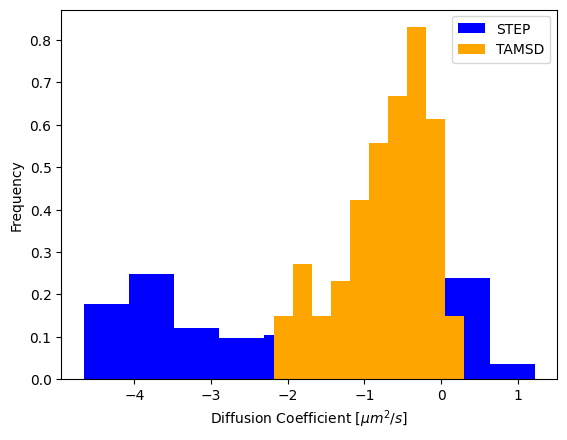

In [63]:
#Representation of Dif Coef of one dataset
data1 = torch.cat(pred_d).numpy()
data2 = tamsd_dif
bin_size1 = int(np.ceil(np.log2(len(data1))) + 1)
bin_size2 = int(np.ceil(np.log2(len(data2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(data1, bins=chosen_bin_size, alpha=1, color='blue', label='STEP', density=True)
plt.hist(data2, bins=chosen_bin_size, alpha=1, color='orange', label='TAMSD', density=True)
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

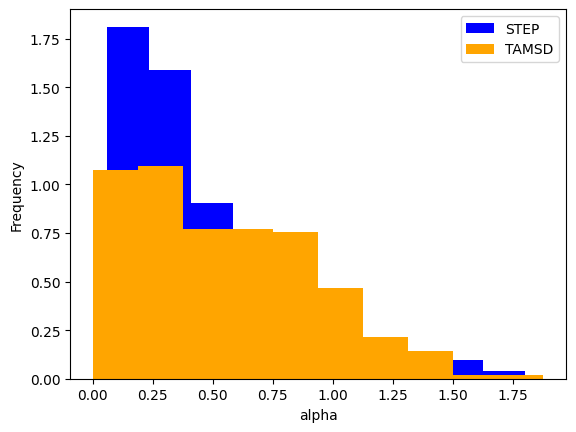

In [64]:
#Representation of alpha of one dataset
data1 = torch.cat(pred_a).numpy()
data2 = tamsd_alpha
bin_size1 = int(np.ceil(np.log2(len(data1))) + 1)
bin_size2 = int(np.ceil(np.log2(len(data2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(data1, bins=chosen_bin_size, alpha=1, color='blue', label='STEP', density=True)
plt.hist(data2, bins=chosen_bin_size, alpha=1, color='orange', label='TAMSD', density=True)
plt.xlabel('alpha')
plt.ylabel('Frequency')
plt.legend()

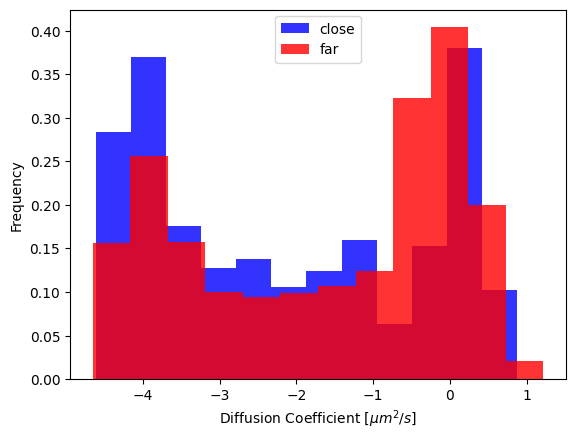

In [22]:
#Filtering of data by close and far
data_close, data_far = [], []
for pred, c in zip(pred_d, close1):
    # Duplicate the last value of preds to match the length of c
    last_pred_value = pred[-1]
    filled_values = torch.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred = torch.cat((pred, filled_values), dim=0)
    # Bolean indexing
    c = torch.abs(c)
    close_pred = pred[c < 3]
    far_pred = pred[c > 3]
    #Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data_close = torch.cat(data_close).numpy()
data_far = torch.cat(data_far).numpy()

#Representation close and far 1 dataset
bin_size1 = int(np.ceil(np.log2(len(data_close))) + 1)
bin_size2 = int(np.ceil(np.log2(len(data_far))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(data_close, bins=chosen_bin_size, alpha=0.8, color='blue', label='close', density=True)
plt.hist(data_far, bins=chosen_bin_size, alpha=0.8, color='red', label='far', density=True)
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

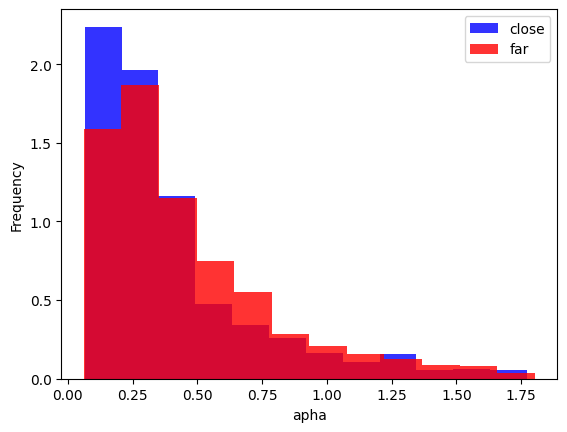

In [23]:
#Filtering of data by close and far
data_close, data_far = [], []
for pred, c in zip(pred_a, close1):
    # Duplicate the last value of preds to match the length of c
    last_pred_value = pred[-1]
    filled_values = torch.full((len(c) - len(pred),), last_pred_value, dtype=pred.dtype, device=pred.device)
    pred = torch.cat((pred, filled_values), dim=0)
    # Bolean indexing
    c = torch.abs(c)
    close_pred = pred[c < 3]
    far_pred = pred[c > 3]
    #Append the data
    data_close.append(close_pred)
    data_far.append(far_pred)
data_close = torch.cat(data_close).numpy()
data_far = torch.cat(data_far).numpy()

#Representation close and far 1 dataset
bin_size1 = int(np.ceil(np.log2(len(data_close))) + 1)
bin_size2 = int(np.ceil(np.log2(len(data_far))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(data_close, bins=chosen_bin_size, alpha=0.8, color='blue', label='close', density=True)
plt.hist(data_far, bins=chosen_bin_size, alpha=0.8, color='red', label='far', density=True)
plt.xlabel('apha')
plt.ylabel('Frequency')
plt.legend()

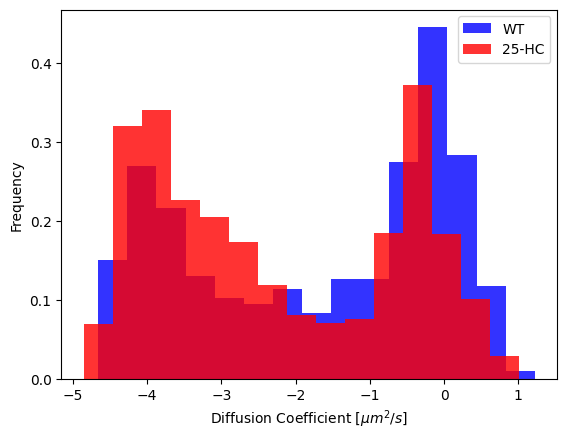

In [24]:
#Representation of both datasets
data = torch.cat(pred_d).numpy()
data2 = torch.cat(pred_d2).numpy()
bin_size1 = int(np.ceil(np.log2(len(data))) + 1)
bin_size2 = int(np.ceil(np.log2(len(data2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(data, bins=chosen_bin_size, alpha=0.8, color='blue', label='WT', density=True)
plt.hist(data2, bins=chosen_bin_size, alpha=0.8, color='red', label='25-HC', density=True)
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [103]:
## Calculating the mean value for te whole trajectory
mean_dif1 = [p.mean().numpy().item() for p in pred_d]
mean_dif2 = [p.mean().numpy().item() for p in pred_d2]
mean_alpha1 = [p.mean().numpy().item() for p in pred_a]
mean_alpha2 = [p.mean().numpy().item() for p in pred_a2]

Text(0, 0.5, 'Frequency')

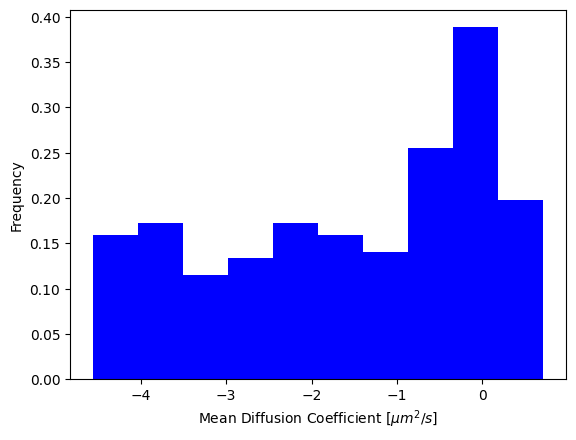

In [26]:
#Representation of one dataset
bin_size = int(np.ceil(np.log2(len(preds_mean))) + 1)
plt.hist(preds_mean, bins=bin_size, alpha=1, color='blue', label='WT', density=True);
plt.xlabel('Mean Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')

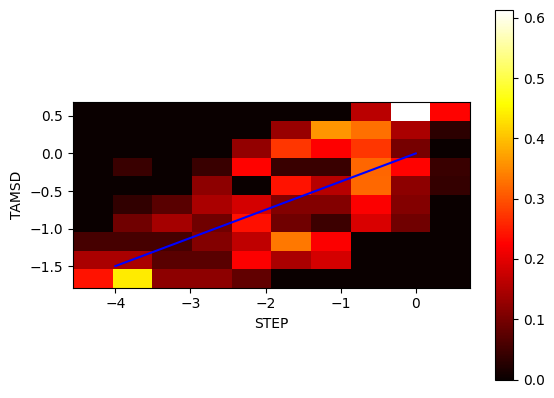

In [105]:
## Heat map STEP vs. TAMSD, dif coef. 
# Process data
data1 = mean_dif1
data2 = tamsd_dif

# Define the number of bins for each variable
bin_size1 = int(np.ceil(np.log2(len(data1))) + 1)
bin_size2 = int(np.ceil(np.log2(len(data2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)

#chosen_bin_size = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data1, data2, bins=[chosen_bin_size, chosen_bin_size])

# Normalize by rows
hist_2d_normalized = hist_2d / hist_2d.sum(axis=1, keepdims=True)

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(-4,0,5), np.linspace(-1.5,0,5), color='blue')

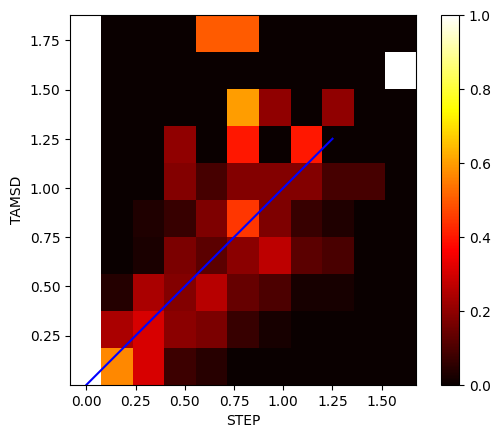

In [108]:
## Heat map STEP vs. TAMSD, alpha
# Process data
data1 = mean_alpha1
data2 = tamsd_alpha

# Define the number of bins for each variable
bin_size1 = int(np.ceil(np.log2(len(data1))) + 1)
bin_size2 = int(np.ceil(np.log2(len(data2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)

#chosen_bin_size = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(data1, data2, bins=[chosen_bin_size, chosen_bin_size])

# Normalize by rows
hist_2d_normalized = hist_2d / hist_2d.sum(axis=1, keepdims=True)

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.plot(np.linspace(0,1.25,5), np.linspace(0,1.25,5), color='blue')

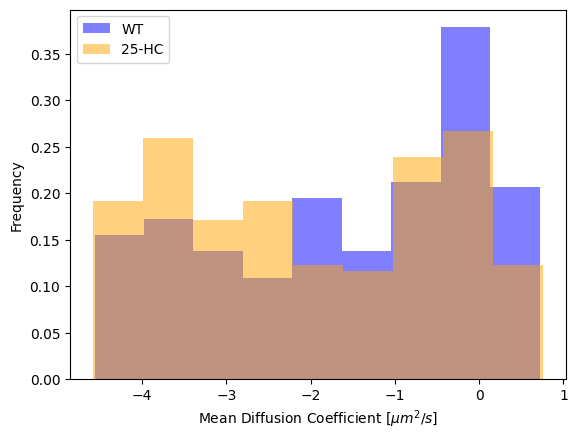

In [27]:
bin_size1 = int(np.ceil(np.log2(len(preds_mean))) + 1)
bin_size2 = int(np.ceil(np.log2(len(preds_mean2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(preds_mean, bins=chosen_bin_size, alpha=0.5, color='blue', label='WT', density=True);
plt.hist(preds_mean2, bins=chosen_bin_size, alpha=0.5, color='orange', label='25-HC', density=True);
plt.xlabel('Mean Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

# Prediction examples

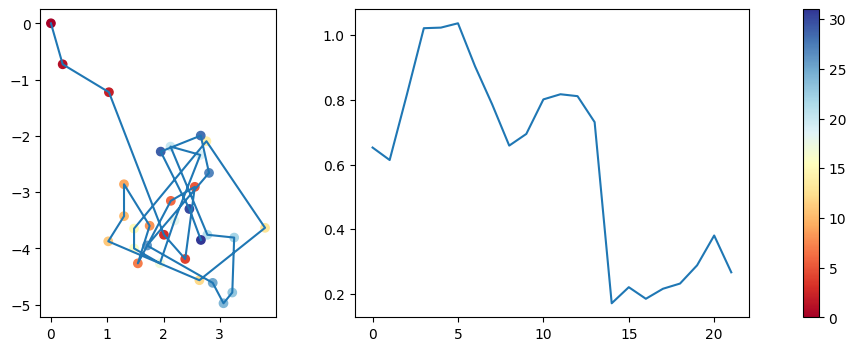

In [109]:
idx = 6
traj = trajectories2[idx]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(traj[0], traj[1])
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = axes[0].scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1, ax=axes)
axes[1].plot(pred_a[idx])
axes[0].set_aspect('equal')

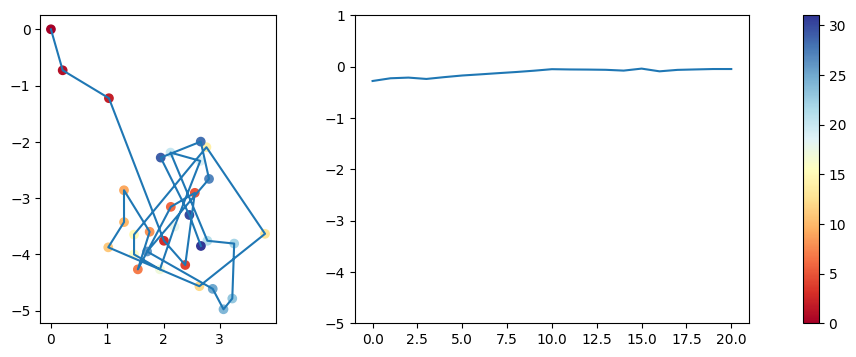

In [110]:
idx = 6
traj = trajectories2[idx]
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(traj[0], traj[1])
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = axes[0].scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1, ax=axes)
axes[1].plot(pred_d[idx])
axes[1].set_ylim(-5, 1)
axes[0].set_aspect('equal')

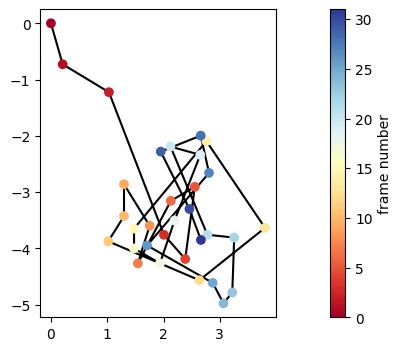

In [26]:
idx = 6
traj = trajectories2[idx]
plt.figure(figsize=(14, 4))
plt.plot(traj[0], traj[1], color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(traj[0], traj[1], c=np.arange(len(traj[0])), cmap=cm1)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('frame number')
plt.gca().set_aspect('equal')

In [28]:
t_lag = [1, 2, 3, 4]
D_tamsd = (diffusion_coefficient_tamsd(tensor(traj).T, t_lag))
print(D_tamsd)

0.22330986559391022


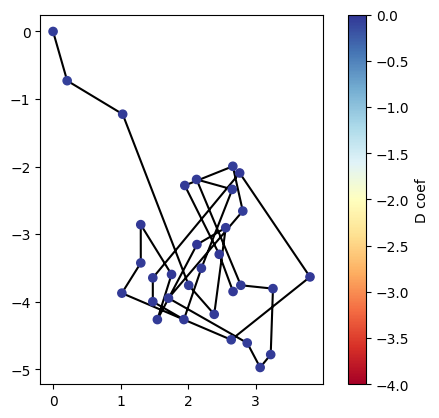

In [132]:
# Select trajectory
idx = 6
traj = trajectories2[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = pred_d2[idx][-1]
preds_idx_extended = np.append(pred_d2[idx], np.full(len(x) - len(pred_d2[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=-4, vmax=0)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('D coef')
plt.gca().set_aspect('equal')

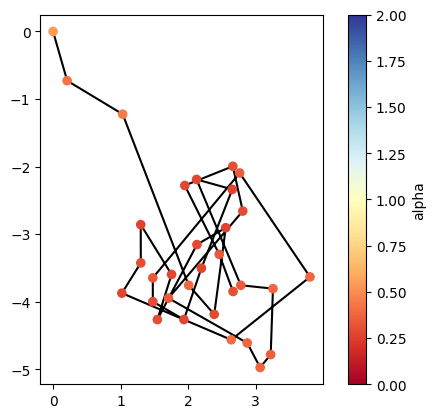

In [133]:
# Select trajectory
idx = 6
traj = trajectories2[idx]
x = traj[0]
y = traj[1]
# Duplicate the last value of preds to match the length of x and y
last_pred_value = pred_a2[idx][-1]
preds_idx_extended = np.append(pred_a2[idx], np.full(len(x) - len(pred_a2[idx]), last_pred_value))
# Plot
plt.figure()
plt.plot(x, y, color='black', zorder=1)
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(x, y, c=preds_idx_extended, s=35, cmap=cm1, zorder=2, vmin=0, vmax=2)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('alpha')
plt.gca().set_aspect('equal')

# Trajectory segmentation

Segmentation only by diffusion coefficient: 

In [32]:
def find_segments(pred, traj, pen=1, **kwargs):
    import ruptures as rpt
    alg = rpt.KernelCPD(**kwargs).fit(pred) # Only changes in D
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, angles = [], [], [], []   
    new_d = np.ones_like(pred)
    d_tamsd = np.ones_like(pred)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        D_seg = pred[i:j].mean()
        new_d[i:j] *= D_seg
        t_lag = [1, 2, 3, 4]
        D_tamsd = np.log10(diffusion_coefficient_tamsd(tensor(segment).T, t_lag))
        d_tamsd[i:j] *= D_tamsd
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)

    return new_d, d_tamsd, segments, Ds, Ds_tamsd, angles

In [35]:
seg_ds, seg_ds_tamsd, seg_angs, trajs, new_Dif, new_tamsd = [], [], [], [], [], []
for traj, pred in tqdm(zip(trajectories1, pred_d)):
    pred = pred.numpy
    x, y = traj[0], traj[1]
    traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
    out = find_segments(pred, traj, min_size=4, pen=1) # previously min_size=10, pen=0.1
    new_d, d_tamsd, segments, d_seg, dtamsd_seg, angs = out
    new_Dif.append(new_d)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_angs.append(angs)
    trajs.append(segments)
seg_ds = np.concatenate(seg_ds)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)

seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]

0it [00:00, ?it/s]

AttributeError: 'builtin_function_or_method' object has no attribute 'astype'

Text(0.5, 0, 'Frame number')

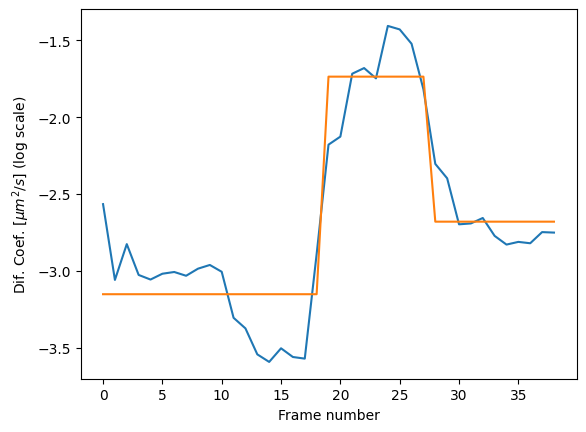

In [18]:
idx = 6
plt.plot(preds[idx])
plt.plot(new_Dif[idx])
plt.ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
plt.xlabel('Frame number')

Text(0, 0.5, 'Frequency')

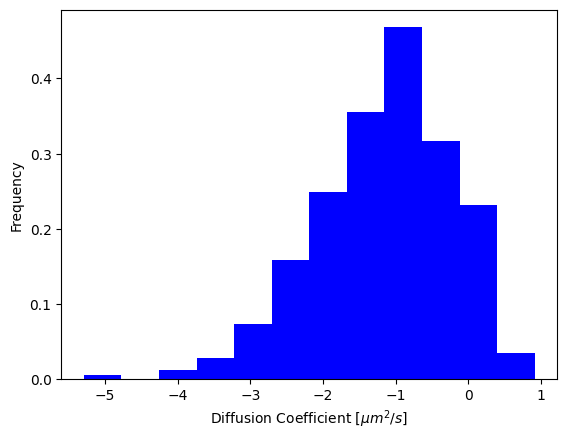

In [30]:
bin_size = int(np.ceil(np.log2(len(seg_ds_tamsd ))) + 1)
plt.hist(seg_ds_tamsd, bins=bin_size, alpha=1, color='blue', label='WT', density=True);
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')

Segmentation by both dif coef and alpha

In [36]:
def inst_MSD_fit(x, D): #Roger's MSD
    y = 2*2*D*x
    return y

In [37]:
def MSD(x, y):
    msd = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        msd[i] = sum(np.square(np.sqrt(np.square(x[i:]-x[:len(x)-i])+np.square(y[i:]-y[:len(x)-i]))))/(len(x)-i)
    return msd

In [38]:
def MSD_fit(x, D, a):
    y = 2*2*D*x**a
    return y

In [107]:
def find_segments2(pred1, pred2, traj, pen=1, **kwargs):
    import ruptures as rpt
    pred = np.column_stack((pred1, pred2)) #concatenate pred_d and pred_alpha
    alg = rpt.KernelCPD(**kwargs).fit(pred)
    cps = np.concatenate(([0], alg.predict(pen=pen)))
    segments, Ds, Ds_tamsd, alphas, angles, alphas_tamsd = [], [], [], [], [], []
    new_d, new_a = np.ones_like(pred1), np.ones_like(pred2)
    d_tamsd = np.ones_like(pred1)
    for i, j in zip(cps[:-1], cps[1:]):
        segment = traj[:, i:j]
        alpha_seg, D_seg = pred2[i:j].mean(), pred1[i:j].mean()
        new_d[i:j] *= D_seg
        new_a[i:j] *= alpha_seg
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0])
        a = parameters[1]
        #t_lag = [1, 2, 3, 4]
        #D_tamsd = np.log10(diffusion_coefficient_tamsd(tensor(segment).T, t_lag))
        d_tamsd[i:j] *= D_tamsd
        
        if np.abs(i-j) > 0:
            angles.append(dataset_angles([segment]))
            segments.append(segment)
        alphas.append(alpha_seg)
        Ds.append(D_seg)
        Ds_tamsd.append(D_tamsd)
        alphas_tamsd.append(a)

    return new_d, d_tamsd, new_a, segments, Ds, Ds_tamsd, alphas, alphas_tamsd, angles

In [40]:
seg_ds, seg_ds_tamsd, seg_angs, seg_alphas, trajs, new_Dif, new_alpha, new_tamsd, seg_alphas_tamsd = [], [], [], [], [], [], [], [], []
for traj, pred1, pred2 in tqdm(zip(trajectories1, pred_d, pred_a)):
    pred1 = pred1.numpy()
    pred2 = pred2.numpy()[:-1] #remove last value
    x, y = traj[0], traj[1]
    traj = np.concatenate([np.zeros((2, 1)), np.array([x, y])], axis=1)
    out = find_segments2(pred1, pred2, traj, min_size=4, pen=1) # previously min_size=10, pen=0.1
    new_d, d_tamsd, new_a, segments, d_seg, dtamsd_seg, alphas, alphas_tamsd, angs = out
    new_Dif.append(new_d)
    new_alpha.append(new_a)
    new_tamsd.append(d_tamsd)
    seg_ds.append(d_seg)
    seg_ds_tamsd.append(dtamsd_seg)
    seg_alphas_tamsd.append(alphas_tamsd)
    seg_angs.append(angs)
    trajs.append(segments)
    seg_alphas.append(alphas)
seg_ds = np.concatenate(seg_ds)
seg_ds_tamsd = np.concatenate(seg_ds_tamsd)
seg_alphas_tamsd = np.concatenate(seg_alphas_tamsd)
seg_alphas = np.concatenate(seg_alphas)
seg_lens = np.array([seg.shape[-1] for traj in trajs for seg in traj])
seg_radi = [[confinement_radius(seg) for seg in traj] for traj in trajs]

0it [00:00, ?it/s]

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_14152\872114572.py:6: RuntimeWarning: invalid value encountered in divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_14152\3704476150.py:2: RuntimeWarning: divide by zero encountered in power
  y = 2*2*D*x**a
C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_14152\4041003691.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])


Text(0.5, 0, 'Frame number')

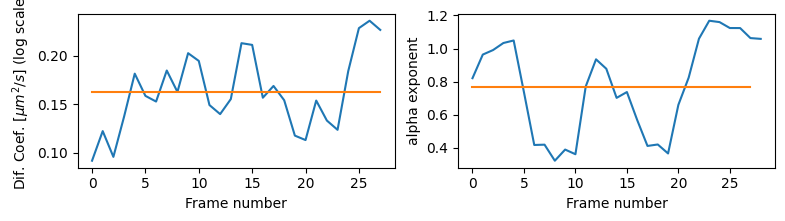

In [41]:
idx = 15
fig, axes = plt.subplots(1, 2, figsize=(9, 2))
axes[0].plot(pred_d[idx])
axes[0].plot(new_Dif[idx])
axes[0].set_ylabel('Dif. Coef. [$\mu m^2/s$] (log scale)')
axes[0].set_xlabel('Frame number')
axes[1].plot(pred_a[idx])
axes[1].plot(new_alpha[idx])
axes[1].set_ylabel('alpha exponent')
axes[1].set_xlabel('Frame number')

Text(0, 0.5, 'STEP')

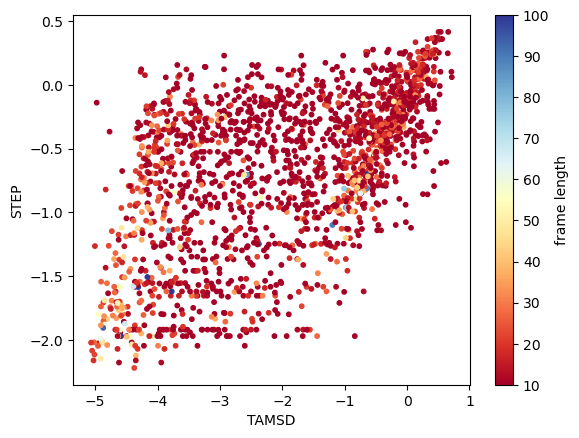

In [82]:
# Comparison D step and D TAMSD
plt.figure()
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(seg_ds, seg_ds_tamsd, c=seg_lens, s=10, cmap=cm1, zorder=2, vmin=10, vmax=100)
cbar1 = plt.colorbar(sc1)
cbar1.set_label('frame length')
plt.xlabel('TAMSD')
plt.ylabel('STEP')
#plt.gca().set_aspect('equal')

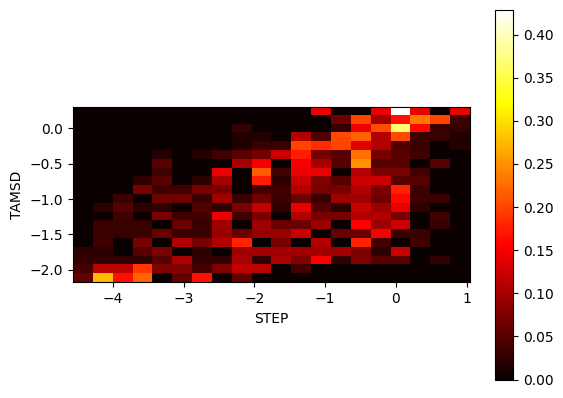

In [53]:
## Heat map STEP vs. TAMSD for Dif. coef. 
# Define the number of bins for each variable
bins_seg_ds = 20
bins_seg_ds_tamsd = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(seg_ds, seg_ds_tamsd, bins=[bins_seg_ds, bins_seg_ds_tamsd])

# Select the ticks you want to display
#start_value = min(xedges[0], yedges[0])
#x_ticks_indices = np.arange(0, len(xedges), len(xedges)//5)
#y_ticks_indices = x_ticks_indices

# Round the tick labels to two decimal places
#x_tick_labels = np.round(xedges[x_ticks_indices], 2)
#y_tick_labels = np.round(yedges[y_ticks_indices], 2)

# Normalize by rows
hist_2d_normalized = hist_2d / hist_2d.sum(axis=1, keepdims=True)

#Plot
#plt.xticks(x_ticks_indices, x_tick_labels)
#plt.yticks(y_ticks_indices, y_tick_labels)
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.gca().set_aspect('equal')
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()

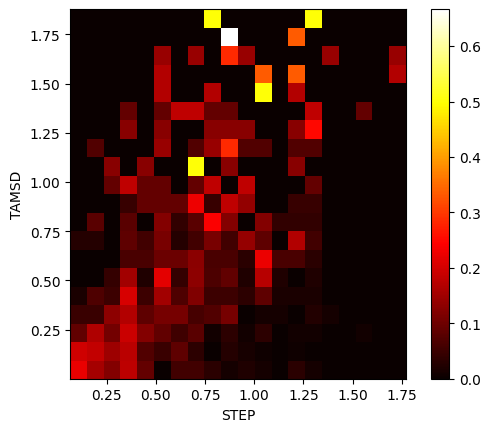

In [55]:
## Heat map STEP vs. TAMSD for alpha
# Define the number of bins for each variable
bins_seg_ds = 20
bins_seg_ds_tamsd = 20

# Compute the 2D histogram
hist_2d, xedges, yedges = np.histogram2d(seg_alphas, seg_alphas_tamsd, bins=[bins_seg_ds, bins_seg_ds_tamsd])

# Normalize by rows
hist_2d_normalized = hist_2d / hist_2d.sum(axis=1, keepdims=True)

#Plot
plt.imshow(hist_2d_normalized, cmap='hot', interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('STEP')
plt.ylabel('TAMSD')
plt.colorbar()
plt.gca().set_aspect('equal')

Text(0, 0.5, 'alpha')

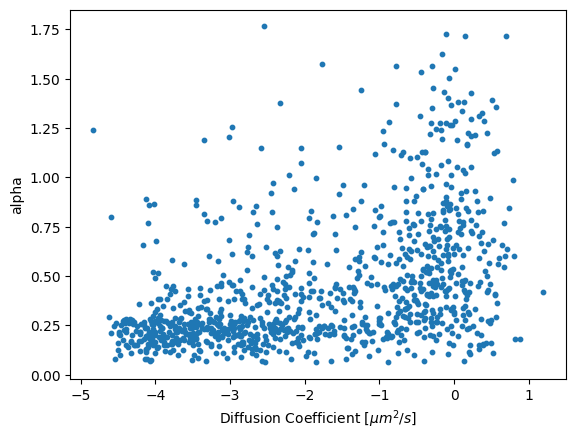

In [327]:
# Relationship diff. coef. and alpha
plt.figure()
cm1 = matplotlib.colormaps['RdYlBu']
sc1 = plt.scatter(seg_ds, seg_alphas, s=10)
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('alpha')

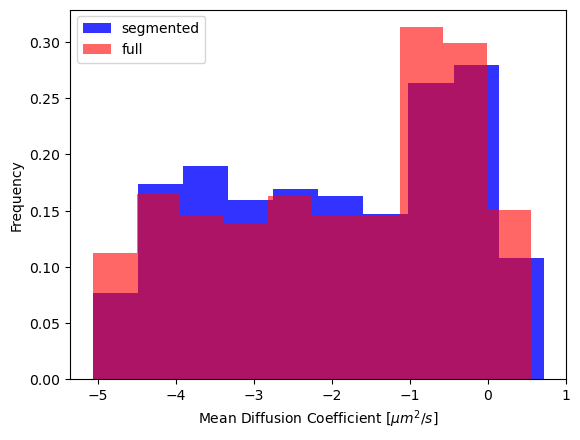

In [114]:
# Comparison before and after segmentation diff. coef. 
bin_size = int(np.ceil(np.log2(len(preds_mean2))) + 1)
plt.hist(seg_ds, bins=bin_size, alpha=0.8, color='blue', label='segmented', density=True);
plt.hist(preds_mean, bins=bin_size, alpha=0.6, color='red', label='full', density=True);
plt.xlabel('Mean Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

In [330]:
# Dif. coef. and alpha for short trajectories calculated with TAMSD
constant_value = torch.tensor(np.log10(0.1567**2/0.01), dtype=torch.float32)
short_traj, pred_d_short = [], [],
for traj in (all_trajectories2):
    length = len(traj[0])
    if 12 < length < 20:
        msd = MSD(x,y)
        t = np.arange(0,int(len(msd)))
        inst_parameters, inst_covariance = curve_fit(inst_MSD_fit, t[0:4], msd[0:4]) #Roger's MSD
        parameters, covariance = curve_fit(MSD_fit, t[0:round(len(x)*0.3)], msd[0:round(len(x)*0.3)])
        D_tamsd = np.log10(inst_parameters[0])
        a = parameters[1]
        pred_d_short.append(D_tamsd + constant_value)
        short_traj.append(traj)
all_dif2 = np.concatenate((seg_ds, pred_d_short))

C:\Users\jangulo\AppData\Local\Temp\6\ipykernel_39320\722694994.py:8: RuntimeWarning: invalid value encountered in log10
  D_tamsd = np.log10(diffusion_coefficient_tamsd(tensor(traj).T, t_lag))


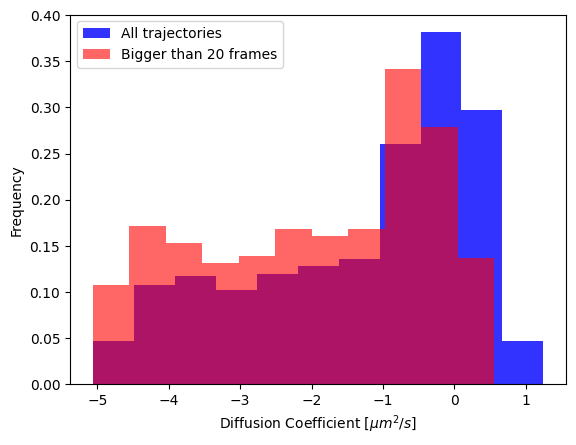

In [312]:
# Comparison before and after segmentation diff. coef. 
bin_size = int(np.ceil(np.log2(len(preds_mean))) + 1)
plt.hist(all_dif, bins=bin_size, alpha=0.8, color='blue', label='All trajectories', density=True);
plt.hist(preds_mean, bins=bin_size, alpha=0.6, color='red', label='Bigger than 20 frames', density=True);
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()

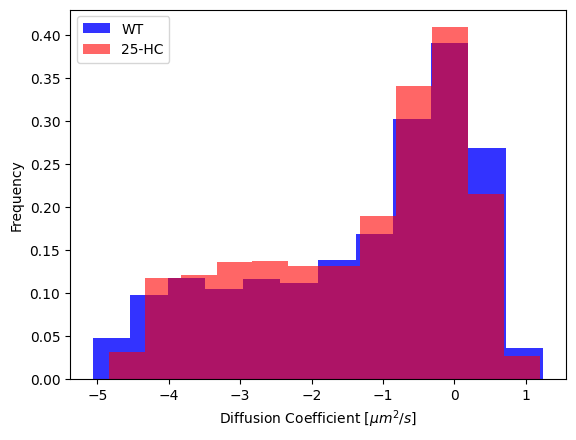

In [336]:
# Comparison 2 datasets for all Dif. coef. 
bin_size1 = int(np.ceil(np.log2(len(all_dif))) + 1)
bin_size2 = int(np.ceil(np.log2(len(all_dif2))) + 1)
chosen_bin_size = min(bin_size1, bin_size2)
plt.hist(all_dif, bins=chosen_bin_size, alpha=0.8, color='blue', label='WT', density=True);
plt.hist(all_dif2, bins=chosen_bin_size, alpha=0.6, color='red', label='25-HC', density=True);
plt.xlabel('Diffusion Coefficient [$\mu m^2/s$]')
plt.ylabel('Frequency')
plt.legend()